In [2]:
def plot_price(C_xt, rho_xt, n_xt,P_prices,alphavals):
    C_xt, rho_xt, n_xt = np.array(C_xt),np.array(rho_xt),np.array(n_xt)
    X = np.linspace(1, sim.Length, sim.nx)
    Pacquisitions = np.sum(Vmax*(C_xt/bp/(C_xt/bp+sim.Kp))*rho_xt*X*sim.dx,axis=1) #ug.h-1.mm-2

    Pacquisitions *= 2*sim.r0*np.pi #ug.h-1
    print(np.mean(Pacquisitions))
    Ccost = np.sum(n_xt*X*sim.dx*sim.v_sval,axis=1) #mm.h-1
    Ccost *= np.pi*(sim.r0)**2 #mm**3.h-1
    Ccost *= (sim.v_sval/0.25)**(sim.speed_penalty)

    Ccost *= 0.5*0.21*1.1 *1e-3 #g.mm-1.h-1
    Ccost *= 1e6 #ug.mm-1.h-1
    Ccost *= 2 #respiration# centimeters in inches

    fig,ax = plt.subplots()
    ax.scatter(Pacquisitions,Ccost,s=0.11)
    ax.plot(Pacquisitions,Pacquisitions*Pprice_ideal,color="red")

Vmax = 3.25e-9 #ugP/um2/hour
Vmax = Vmax*1e6 #ugP.mm-2.hour-1
DP = 1e-5 #cm**2-s-1, diffusion coefficient of small ions in water
DP = DP*1e2*3600 #mm**2-h-1, diffusion coefficient of small ions in water
C0 = 3.5 #ug/mL=ug/cm**-3
C0 = 3.5*1e-3 #ug/mm**-3

DP,Vmax,C0

C0 = 500 #mg.L-1
C0 = 500*1e3 #ug.L-1
C0 = C0 * 1e-3 #ug.cm-3
C0 = C0 *1e-3 #ug.cm-3
Km = 1e-3 #umol/cm3
Km *= 31 #ug/cm3
Km *=1e-3 #ug/mm3
Km_snchepf = Km #to avoid very low timestep 
bp = 239
def signed_sqrt(x,alpha = 1/2):
    """Return the signed square root of a number."""
    if x >= 0:
        return x**alpha
    else:
        return -(-x)**alpha

import sys
sys.path.append('/home/cocopyth/miniconda3/lib/python3.9/site-packages')
print(sys.path)


# !pip install tqdm
from tqdm.notebook import tqdm  # Import tqdm

cm = 1/2.54  # centimeters in inches

%matplotlib widget
from dolfin import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import matplotlib.ticker as ticker

Length = 140*1.5
nx = 350*15//10
Length = 140*0.6
nx = int(350*15//10*0.6/0.8)
plt.close("all")
set_log_active(False)
cmap3 = mpl.cm.get_cmap("autumn")
cmap4 = mpl.cm.get_cmap("summer")

class Simulation:
    """
    A class for simulating a finite element problem using the FEniCS framework.

    Attributes:
    -----------
    Length: float
        Length of the interval domain.
    nx: int
        Number of subdivisions in the mesh.
    nT: int
        Number of time steps.
    T: float
        Total simulation time.
    C0: float
        Initial concentration value.
    Fmax: float
        Maximum flux value.
    Pprice_ideal: float
        Ideal price value.
    width: float
        Width of the plot.
    height: float
        Height of the plot.
    """
    def __init__(self, Length=Length, nx=nx, nT=200, T=400, C0=10, Fmax=2, Pprice_ideal=20, width=3*cm, height=7*cm,speed = 0.230,adaptation_rate = 1e-4,drag = 0):
        self.Length = Length
        self.nx = nx
        self.dx = Length/nx
        self.nT = nT
        self.T = T
        self.dt = T/nT
        self.C0 = C0 #ug.mm-3
        self.Fmax = Fmax
        self.Pprice_ideal = Pprice_ideal
        self.width = width
        self.height = height
        self.speed = speed
        self.adaptation_rate = adaptation_rate
        self.speed_penalty = drag
        self._setup_simulation()
        self.r0 = 3e-3

    def _setup_simulation(self):
        # Set up the simulation: define mesh, function spaces, initial conditions, etc.
        """
        Sets up the initial conditions and parameters for the simulation.
        """
        # Create mesh and define function space
        self.mesh = IntervalMesh(self.nx, 1, self.Length)
        P1 = FiniteElement('P', interval, 1)
        element = MixedElement([P1, P1, P1])
        self.V = FunctionSpace(self.mesh, element)

        # Define initial conditions
        u0 = Expression(('1*exp(-1.2*pow(abs(x[0]-7),2))', 
                         f'(1-exp(-0.1*(x[0]-1)))*{self.C0}', '0*exp(-0.03*pow(abs(x[0]),2))'), degree=1)
        rexp = Expression(('1/x[0]', '0', '0'), degree=1)
        self.r = interpolate(rexp, self.V)
        self.invr, _, _ = split(self.r)
        self.u_n = interpolate(u0, self.V)

        # Splitting functions for later use
        self.u = Function(self.V)
        self.n, self.C, self.rho = split(self.u)   #mm-3,ug.mm-3,mm2.mm-3
        self.n_n, self.C_n, self.rho_n = split(self.u_n)
        self.v_1, self.v_0, self.v_2 = TestFunctions(self.V)

        # Set parameters and constants
        self.dt = self.T / self.nT
        self.alphval = 0.039 #.h-1
        self.alphval0 = self.alphval
        self.betaval = 0.022 #mm.h-1 length coefficient
        # self.betaval = 0.022/(2.5e-3) #mm.h-1 SA coefficient
        
        self.beta = Constant(self.betaval) #mm**4.h-1
        self.D = 0.00008 #mm**2.h-1
        self.D0 = self.D #mm**2.h-1
        
        self.D2 = Constant(3.6) #mm**2.h-1
        self.n_mid = 0.5*(self.n_n + self.n)
        self.v_sval = self.speed #mm.h-1
        self.s_scal = self.speed #mm.h-1
        self.v_s = Constant((self.v_sval,)) #mm.h-1
        self.Vmax = self.Fmax #ug.mm**-2.h-1
        self.Kp = Km_snchepf #ug.mm-3
        # Boundary conditions
        u_L = (Constant(0.0), Constant(0.0), Constant(0.0))
        u_R = (Constant(0.0), Constant(self.C0), Constant(0.0))
        bc_L = DirichletBC(self.V, u_L, 'near(x[0], 1.0)')
        bc_R = DirichletBC(self.V, u_R, f'near(x[0], {self.Length})')
        self.bcs = [bc_L, bc_R]

    def _make_F(self, alphval,D,sval):
        # Define the variational problem F
        alpha = Constant(alphval)
        D = Constant(D)
        s_scal = Constant(sval)
        C_L =  self.C/bp
        
        # dn/dt
        F = self.n*self.v_1*dx - self.n_n*self.v_1*dx 
        # D lapplacian(n)
        F += D*dot(grad(self.n), grad(self.v_1))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*D*dot(grad(self.n), Constant((1,)))*self.v_1*self.dt*dx
        
        #v.grad(n)
        F += self.dt*dot(grad(self.n_mid),self.v_s)*self.v_1*dx
        # To account for cylindrical coordinates
        F += self.invr*self.dt*self.n_mid*Constant(self.v_sval)*self.v_1*dx
        
        #alpha*n - beta * n * rho
        F += self.beta*self.v_1*self.rho*(self.n)*self.dt*dx
        F -= alpha*(self.n)*self.v_1*self.dt*dx
        #d rho/dt = vn
        F -= self.dt*s_scal*self.n*self.v_2*dx-(self.rho-self.rho_n)*self.v_2*dx


        # dC/dt
        F += self.C*self.v_0*dx - self.C_n*self.v_0*dx #ug.mm-3
        # Vmax * rho * C/(C+Kp)
        F += 2*np.pi*self.Vmax*(self.rho)*self.r0*(self.C/bp/(self.Kp+self.C/bp))*self.v_0*self.dt*dx #ug
        # Diffusion 
        F += self.D2*dot(grad(self.C/bp), grad(self.v_0))*self.dt*dx
        # To account for cylindrical coordinates
        F += self.invr*self.D2*dot(grad(self.C/bp), Constant((1,)))*self.v_0*self.dt*dx

        return F
    def integrate(self, plot=False,remove_ylabels = False):
        """
        Integrate the problem over time and optionally plot the results.
        Returns arrays of C(x, t), rho(x, t), and n(x, t) over the simulation.

        Parameters:
        -----------
        plot: bool
            If True, plot the results using matplotlib.

        Returns:
        --------
        C_xt: list of arrays
            Concentration C as a function of position x and time t.
        rho_xt: list of arrays
            Density rho as a function of position x and time t.
        n_xt: list of arrays
            Quantity n as a function of position x and time t.
        """
        # Initialize arrays to store C(x, t), rho(x, t), and n(x, t)
        C_xt = []
        rho_xt = []
        n_xt = []
        P_prices = []
        alphavals = []
        # Initialize matplotlib plots if needed
        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(self.width, self.height*1.5))
            cmap = mpl.cm.get_cmap("winter")
            cmap2 = mpl.cm.get_cmap("spring")

        # Time-stepping loop
        V2 = FunctionSpace(self.mesh, 'P', 1)
        X = np.linspace(1, self.Length, self.nx)
        i=0
        tot_CCosts= [] 
        tot_Pacqus = []
        for t in tqdm(np.linspace(0, self.T, self.nT), desc="Simulating"):
            F = self._make_F(self.alphval,self.D,self.s_scal)
            solve(F == 0, self.u, self.bcs)
            self.u_n.assign(self.u)
            _n, _C, _rho = self.u.split()

            # Interpolate and store the results
            n_field = interpolate(_n, V2)
            rho_field = interpolate(_rho, V2)
            C_field = interpolate(_C, V2)
            Ccost = np.pi*np.sum([n_field(x)*x*self.dx*self.v_sval for x in X]) #mm.h-1
            Ccost *= np.pi*(self.r0)**2 #mm**3.h-1
            Ccost *= 1e-3  #mL.mm-1.h-1=dm**3.h-1
            
            Ccost *= 0.5*0.21*1.1 #g.h-1
            Ccost *= 1e6 #ug.h-1
            Ccost *= 2 #respiration
            
            Ccost *= (self.v_sval/0.25)**(self.speed_penalty)
            Pacquisition = np.pi*np.sum([self.Vmax*(C_field(x)/bp/(C_field(x)/bp+self.Kp))*rho_field(x)*x*self.dx for x in X]) #ug.h-1.mm-2
            Pacquisition *= 2*self.r0*np.pi #ug.mm-1
            # Pacquisition += 5e-4*np.exp(-t/100)
            tot_CCosts.append(Ccost) 
            tot_Pacqus.append(Pacquisition)
            # Pprice = Ccost/Pacquisition
            integrated_CCost = np.sum(tot_CCosts[-10*self.T//self.nT:])
            integrated_Pacqu = np.sum(tot_Pacqus[-10*self.T//self.nT:])
            
            Pprice = integrated_CCost/integrated_Pacqu

            alphavals.append(self.alphval)
            if t>=0:
                # self.s_scal = self.Pprice_ideal/Pprice*self.speed
                self.alphval = max(0.001,self.alphval + self.dt*self.adaptation_rate*(t/50)**2*signed_sqrt((self.Pprice_ideal-Pprice)/self.Pprice_ideal,alpha = 1))
            # print(self.alphval)
            self.D = self.D0*self.alphval0/self.alphval
            # print(2*(np.sqrt(self.D*self.alphval)))
            n_xt.append([n_field(x) for x in X])
            rho_xt.append([rho_field(x) for x in X])
            C_xt.append([C_field(x) for x in X])
            P_prices.append(Pprice)
            # print(Pprice,self.alphval)
            if plot and i % (self.nT//5) == 0:
                axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
                axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
                axs[2].plot(X, np.array(C_xt[-1])*1000, color=cmap3(t / self.T))
                Pacq =  [2*self.r0*np.pi*C_xt[-1][i]/bp/(C_xt[-1][i]/bp+self.Kp) * rho_xt[-1][i]*Vmax*1000 for i in range(len(X))]

                axs[3].plot(X, Pacq, color=cmap4(t / self.T))
                # break
            i+=1
            

        # Finalize plot settings if plotting
        if plot:
            axs[1].plot(X, n_xt[-1], color=cmap2(t / self.T))
            axs[0].plot(X, rho_xt[-1], color=cmap(t / self.T))
            satrho = np.median([rho for rho in rho_xt[-1] if rho>1e-10])
            
            # axs[0].hlines(satrho,np.min(X),np.max(X), color="red")
            
            axs[2].plot(X, np.array(C_xt[-1])*1000, color=cmap3(t / self.T))
            Pacq =  [2*self.r0*np.pi*C_xt[-1][i]/bp/(C_xt[-1][i]/bp+self.Kp) * rho_xt[-1][i]*Vmax*1000 for i in range(len(X))]
            axs[3].plot(X, Pacq, color=cmap4(t / self.T))
            axs[0].set_ylabel(r'$\rho$'+ '\n $(mm^{-2})$')
            axs[0].set_xticklabels([])
            # axs[0].set_ylim(0,8)
            
            axs[1].set_ylabel('$n$ \n $(mm^{-3})$')
            axs[1].set_xticklabels([])
            # axs[1].set_ylim(0,3)
            
            axs[2].set_ylabel('$[P]$ \n ($ng/ mm^{3}$)')
            axs[2].set_xticklabels([])
            # axs[2].set_ylim(0,13)
            
            axs[3].set_ylabel('$\phi_P$ \n ($ng/mm^{3}/h$)')

            axs[3].set_xlabel('position \n ($mm$)')
            # axs[3].set_ylim(0,0.05)

            formatter = ticker.FormatStrFormatter('%.2f')  # Adjust format as needed

            for ax in axs:
                ax.yaxis.set_major_formatter(formatter)
            if remove_ylabels:
                for ax in axs:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

            plt.show()

        return C_xt, rho_xt, n_xt,P_prices,alphavals
        

# Example usage:
C0=0.02
Pprice_ideal = 2*(0.02/C0)**(1/1.2)
speed = 0.10
T = 200
nT = 400
adaptation_rate = 8e-2

sim = Simulation(speed = speed,C0=C0,T = T,nT=nT,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = adaptation_rate,drag = 1)
# C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)
# plot_price(C_xt, rho_xt, n_xt,P_prices,alphavals)
# speed = 0.26
# sim = Simulation(speed = speed,C0=C0,T = T,nT=nT,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = adaptation_rate,drag = 1)
# C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)
# plot_price(C_xt, rho_xt, n_xt,P_prices,alphavals)

# speed = 0.17
# sim = Simulation(speed = speed,C0=C0,T = T,nT=nT,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = adaptation_rate,drag = 1)
# C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)
# plot_price(C_xt, rho_xt, n_xt,P_prices,alphavals)

# C0=0.05
# sim = Simulation(speed = speed,C0=C0,T = T,nT=nT,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = adaptation_rate,drag = 1)
# C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)
# plot_price(C_xt, rho_xt, n_xt,P_prices,alphavals)

# speed = 0.10
# sim = Simulation(speed = speed,C0=C0,T = T,nT=nT,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = adaptation_rate,drag = 1)

# C_xt, rho_xt, n_xt,P_prices,alphavals = sim.integrate(plot=True)
# plot_price(C_xt, rho_xt, n_xt,P_prices,alphavals)


['/home/cocopyth/PandC', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/cocopyth/.local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/petsc/lib/python3/dist-packages', '/usr/lib/mshr/python3/dist-packages', '/usr/lib/slepc/lib/python3/dist-packages', '/home/cocopyth/miniconda3/lib/python3.9/site-packages']


/tmp/ipykernel_76/7479857.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap3 = mpl.cm.get_cmap("autumn")
/tmp/ipykernel_76/7479857.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap4 = mpl.cm.get_cmap("summer")


In [5]:
Length

84.0

In [2]:
Pprice_ideal = 2*(0.02/C0)**(1/3)
Pprice_ideal

2.0

In [3]:
def get_dynamics(speed,C0=10,Pprice_ideal = 1/15):
    sim = Simulation(speed = speed,C0=C0,T = T,nT=nT,Pprice_ideal = Pprice_ideal,Fmax = Vmax,adaptation_rate = adaptation_rate,drag = 1)
    C_xt, rho_xt, n_xt,P_prices,_ = sim.integrate(plot=False)
    poss = np.argmax(n_xt,axis=1)
    x = np.linspace(0,sim.T,sim.nT)
    y = np.array(poss)*sim.Length/sim.nx
    fit_coeffs = np.polyfit(x[3*sim.nT//4:], y[3*sim.nT//4:], 1)
    return(np.array(C_xt),np.array(rho_xt),np.array(n_xt),fit_coeffs[0])


In [4]:
plt.close("all")

speeds = np.linspace(0.10,0.26,10)
C0_values = np.exp(np.linspace(np.log(0.001), np.log(0.02), 10))  # Adjust the number of points as needed

dynamics = {(speed, C0): get_dynamics(speed, C0=C0, Pprice_ideal=2*(0.02/C0)**(1/1.2)) 
            for C0 in C0_values for speed in speeds}

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating:   0%|          | 0/400 [00:00<?, ?it/s]

In [5]:
X = np.linspace(1, Length, nx)
dx = Length/nx
Pacqu = {}

for speed in speeds:
    for C0 in C0_values:
        C_xt, rho_xt, n_xt,speed_observed = dynamics[(speed,C0)]
        Pacquisitions = np.sum(Vmax*(C_xt/bp/(C_xt/bp+sim.Kp))*rho_xt*X*sim.dx,axis=1) #ug.h-1.mm-1
        Pacquisitions *= 2*sim.r0*np.pi
        Pacqu[(speed,C0)] = np.mean(Pacquisitions)

In [6]:
import pandas as pd

# Your existing code
# X, dx, Pacqu, etc.

# Convert your data into a list of dictionaries
data_for_df = []
for key, value in Pacqu.items():
    speed, C0 = key
    data_for_df.append({'speed': speed, 'C0': C0, 'MeanPacquisition': value})

# Create DataFrame
df = pd.DataFrame(data_for_df)

# Display the DataFrame


df.to_csv('speedC0.csv')

average_p_rate = df.groupby('C0')['MeanPacquisition'].mean()

# Merge the averages back into the original DataFrame
df['average_P_rate'] = df['C0'].map(average_p_rate)
df['normalized_P_rate'] = df['MeanPacquisition']/df['average_P_rate']


def to_two_significant_digits(x):
    return float(f'{x:.2g}')

# Create new columns with values formatted to two significant digits
df['speed'] = (df['speed'].apply(to_two_significant_digits)*1000).astype(int)
df['C0'] = (df['C0'].apply(to_two_significant_digits)*1000).astype(int)



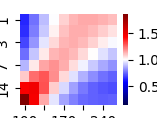

In [7]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig5"
cm = 1/2.54  # centimeters in inches

import seaborn as sns
from matplotlib.ticker import FuncFormatter
fig,ax = plt.subplots(figsize = (4*cm,3*cm))

pivot_df = df.pivot_table(index='C0', columns='speed', values='normalized_P_rate')
max_value = pivot_df.abs().max().max()  # Find the maximum absolute value
vmin, vmax = 2-max_value, max_value  # Set vmin and vmax for the colorbar

# Create the heatmap with symmetric colorbar
sns.heatmap(pivot_df, annot=False, cmap="seismic", ax=ax, vmin=vmin, vmax=vmax)

# sns.heatmap(pivot_df, annot=False, cmap="YlGnBu",cbar_kws={'label': 'relative \n P transfer'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

n = 2  # Set n to desired interval
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % n != 0:
        label.set_visible(False)
# n = 2  # Set n to desired interval
# for index, label in enumerate(ax.yaxis.get_ticklabels()):
#     if index % n != 0:
        # label.set_visible(False)
ax.set_xlabel('$v_{wave}$ ($\mu m/h$)')
ax.set_ylabel('$[P]_{0}$ \n ($n g/mm^3$)')
# plt.tight_layout()
plt.savefig(os.path.join(path_figure,'Figure4modelB.pdf'), transparent=True, bbox_inches='tight')


In [8]:
ggégé

NameError: name 'ggégé' is not defined

In [ ]:
X = np.linspace(1, Length, nx)
dx = Length/nx
Pacqu = {}
for speed in speeds:
    C_xt, rho_xt, n_xt = dynamics[speed] 
    Pacquisitions = np.sum(Vmax*(C_xt/(C_xt+sim.Kp))*rho_xt*X*sim.dx,axis=1) #ug.h-1.mm-1
    Pacquisitions *= 2*sim.r0*np.pi
    Pacqu[speed] = Pacquisitions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# Your data setup

ts = np.linspace(0, T, nT)

# Choose a colormap
cmap = get_cmap('viridis')  # You can choose other colormaps like 'plasma', 'inferno', 'magma', 'cividis'

# Normalize your speeds for the colormap
norm_speeds = (speeds - min(speeds)) / (max(speeds) - min(speeds))

# Create the plot
fig, ax = plt.subplots()

# Plot each line with color based on speed
for i, speed in enumerate(speeds):
    ax.plot(ts, Pacqu[speed], label=f'{speed}', color=cmap(norm_speeds[i]))
    print(np.mean(Pacqu[speed]))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# Your data setup

ts = np.linspace(0, T, nT)

# Choose a colormap
cmap = get_cmap('viridis')  # You can choose other colormaps like 'plasma', 'inferno', 'magma', 'cividis'

# Normalize your speeds for the colormap
norm_speeds = (speeds - min(speeds)) / (max(speeds) - min(speeds))

# Create the plot
fig, ax = plt.subplots()

# Plot each line with color based on speed
for i, speed in enumerate(speeds):
    ax.plot(ts, Pacqu[speed], label=f'{speed}', color=cmap(norm_speeds[i]))
    print(np.mean(Pacqu[speed]))


In [ ]:
path_figure = r"/mnt/c/Users/coren/Documents/PhD/paper/PandC/Fig4"


In [ ]:
plt.style.use('presentation.mplstyle')
cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (6*cm,4*cm))
ax.plot(np.array(speeds)*1000,rho_sats)
fit_coeffs = np.polyfit(speeds, rho_sats, 1)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel('$v_{wave}$ (um/h)')
ax.set_ylabel('$d_{L}$ \n ($mm/mm^2$)')
# plt.tight_layout()
plt.savefig(os.path.join(path_figure,'Figure4modelA.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
fig,ax = plt.subplots()
ax.scatter(speeds,speeds_observed)
fit_coeffs = np.polyfit(speeds, speeds_observed, 1)
x = [0,0.30]
fit_line = np.polyval(fit_coeffs, x)

# Plot data and linear fit
ax.plot(x, fit_line, 'r--')
# ax.set_xscale("log")
# ax.set_yscale("log")